<a href="https://colab.research.google.com/github/hoangviet-nguyen/bveri-abschluss-projekt/blob/main/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Bveri-Abschluss')

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

Mounted at /content/drive
black not installed


# Projekt: Under Water Image Segmentation

In [2]:
!pip install torchinfo torchshow -q
import os
from pathlib import Path
import suim_set
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.v2 import functional as TF
import torch
import torchshow as ts
from torch.utils.data import Dataset
from typing import Callable
import torchinfo
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Download dataset: SUIM dataset

In [4]:
DATA_PATH = Path("./workspace/code/data")

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    suim_set.download(DATA_PATH)

Downloading...
From (original): https://drive.google.com/uc?id=1hsTc6XeL59WDQIj0EOMZXdtT-Af0RcOg
From (redirected): https://drive.google.com/uc?id=1hsTc6XeL59WDQIj0EOMZXdtT-Af0RcOg&confirm=t&uuid=8173cc06-7ef7-40c6-b959-de5ad737e4f1
To: /content/workspace/code/data/train_val.zip
100%|██████████| 172M/172M [00:02<00:00, 84.1MB/s]


File downloaded and saved to workspace/code/data/train_val.zip
Starting to extract... workspace/code/data/train_val
File extracted to workspace/code/data/train_val


Downloading...
From: https://drive.google.com/uc?id=1YZBFO_tEmP5aImfrH01nDu4Kg1wtvklX
To: /content/workspace/code/data/TEST.zip
100%|██████████| 12.8M/12.8M [00:00<00:00, 27.8MB/s]


File downloaded and saved to workspace/code/data/TEST.zip
Starting to extract... workspace/code/data/TEST
File extracted to workspace/code/data/TEST


## Data Inspection

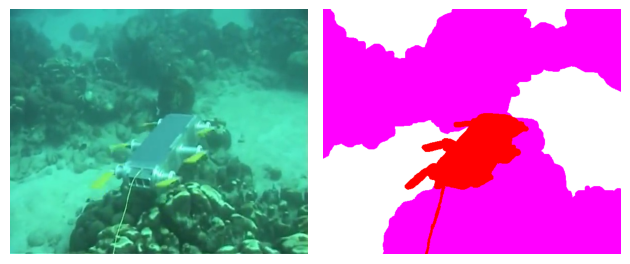

In [5]:
root_path = DATA_PATH.joinpath("train_val/train_val")
norm_img = Image.open(root_path.joinpath("images/d_r_1_.jpg"))
norm_img = np.array(norm_img)

label_img = Image.open(root_path.joinpath("masks/d_r_1_.bmp"))
label_img = np.array(label_img) / 255
imgs = [norm_img, label_img]

fig, axs = plt.subplots(ncols=2)
for img, ax in zip(imgs, axs.flatten()):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show();

## Building a dataset

In [6]:
class SuimDataSet(Dataset):
    def __init__(
        self,
        root_path: Path,
        transform_images: Callable = None,
        transform_labels: Callable = None,
    ):
        """
        Initializes the dataset.

        Args:
            root_path (Path): Path to the dataset directory.
            transform_images (callable, optional): Transformation function for images.
            transform_labels (callable, optional): Transformation function for labels.
        """

        self.root_path = root_path
        self.transform_images = transform_images
        self.transform_labels = transform_labels
        self.image_paths = list((root_path / "images").glob("*.jpg"))

        self.rgb_to_class = {
            (0, 0, 0): 0,  # Black - Background waterbody
            (0, 0, 255): 1,  # Blue - Human divers
            (0, 255, 0): 2,  # Green - Plants/sea-grass
            (0, 255, 255): 3,  # Sky blue - Wrecks/ruins
            (255, 0, 0): 4,  # Red - Robots/instruments
            (255, 0, 255): 5,  # Pink - Reefs/invertebrates
            (255, 255, 0): 6,  # Yellow - Fish and vertebrates
            (255, 255, 255): 7,  # White - Sea-floor and rocks
        }

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(
        self, idx: int
    ) -> tuple[torch.Tensor | Image.Image, torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and corresponding label masks for a given index.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing:
                - image (torch.Tensor | Image.Image): The transformed image or original image.
                - label_masks (torch.Tensor): A binary mask tensor of shape (K, H, W) where K is the number of classes.
                  Each channel represents the binary mask for a specific class.
                - labels_tensor (torch.Tensor): A segmentation map tensor of shape (1, H, W) indicating class indices
                for each pixel.
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        label_path = self.root_path / f"masks/{image_path.stem}.bmp"
        label_img = np.array(Image.open(label_path)) / 255
        labels = np.zeros(label_img.shape[:2], dtype=np.int64)

        for rgb, class_idx in self.rgb_to_class.items():
            x, y, _ = np.where(label_img == np.array(rgb))
            labels[x, y] = class_idx

        labels_tensor = torch.tensor(labels).unsqueeze(0)
        label_masks = torch.zeros(len(self.rgb_to_class), *labels.shape).scatter_(
            0, labels_tensor, 1
        )

        if self.transform_images:
            image = self.transform_images(image)
        if self.transform_labels:
            label_masks = self.transform_labels(label_masks)
            labels_tensor = self.transform_labels(labels_tensor)

        return image, label_masks, labels_tensor

In [7]:
train_path = DATA_PATH.joinpath("train_val/train_val")
test_path = DATA_PATH.joinpath("TEST/TEST")

ds_train = SuimDataSet(root_path=train_path)
ds_test = SuimDataSet(root_path=test_path)

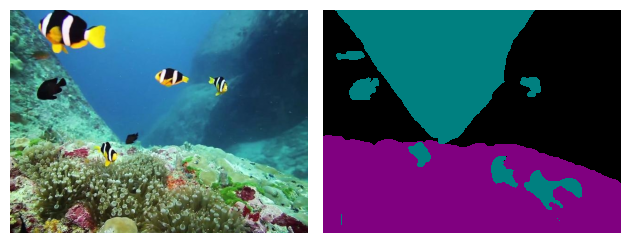

In [8]:
observation, label_masks, label_tensor = ds_train[0]
ts.show([observation, label_tensor])

## Fully-Convolutional Network

### Encoder Block

In [53]:
class EncoderBlock(nn.Module):
    """A basic encoder block that performs convolution, normalization, and activation."""

    def __init__(
        self,
        in_channels: int,
        out_channels: list[int],
        kernel_size=(3, 3),
        padding=1,
        skip=True,
    ):
        super().__init__()
        self.skip = skip

        f1, f2, f3, f4 = out_channels

        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=(1, 1), stride=1)
        self.bn1 = nn.BatchNorm2d(f1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(f1, f2, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(f2)

        self.conv3 = nn.Conv2d(f2, f3, kernel_size=(1, 1))
        self.bn3 = nn.BatchNorm2d(f3)

        self.conv4 = nn.Conv2d(in_channels, f4, kernel_size=(1, 1))
        self.bn4 = nn.BatchNorm2d(f4)

    def forward(self, input_tensor):
        x = input_tensor

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.skip:
            shortcut = input_tensor
        else:
            shortcut = self.conv4(input_tensor)
            shortcut = self.bn4(shortcut)
        x += shortcut
        x = self.relu(x)
        return x
    def __repr__(self):
        return f"EncoderDecoder model with encoder and decoder components."

In [54]:
class Encoder(nn.Module):
    """Encodes an image to a low-dimensional representation.

    Args:
        num_channels_in (int): Number of input channels (e.g., 3 for RGB images).
        num_channels (list[int]): Number of output channels for each block.
            Each block reduces spatial dimensionality by half.
    Input:
        image batch of shape (N, C, H, W)

    Output:
        image batch of shape (N, C2, H / S, W / S), where S is the global stride.
    """

    def __init__(self):
        super().__init__()

        self.initial_conv = nn.Conv2d(3, 64, kernel_size=(5, 5), stride=1, padding=2)
        self.initial_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.block2 = nn.ModuleList(
            [
                EncoderBlock(64,  [64, 64, 128, 128], skip=False),
                EncoderBlock(128, [64, 64, 128, 128], skip=True),
                EncoderBlock(128, [64, 64, 128, 128], skip=True),
                EncoderBlock(128, [64, 64, 128, 128], skip=True),

            ]
        )

        self.block3 = nn.ModuleList(
            [
                EncoderBlock(128, [128, 128, 256, 256], skip=False),
                EncoderBlock(256, [128, 128, 256, 256], skip=True),
                EncoderBlock(256, [128, 128, 256, 256], skip=True),
                EncoderBlock(256, [128, 128, 256, 256], skip=True),
                EncoderBlock(256, [128, 128, 256, 256], skip=True),
            ]
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.relu(x)

        encoded1 = x
        x = self.pool1(x)

        for encoder_block in self.block2:
            x = encoder_block(x)

        x = self.pool1(x)
        encoded2 = x

        for encoder_block in self.block3:
            x = encoder_block(x)

        x= self.pool1(x)
        encoded3 = x

        return [encoded1, encoded2, encoded3]
    def __repr__(self):
        return f"EncoderDecoder model with encoder and decoder components."


### Decoder Block

In [55]:
class Decoder(nn.Module):
    """Decodes a low-dimensional representation back to an image.

    Args:
        num_channels_in (int): Number of input channels (output of encoder)
        num_channels (list[int]): Number of channels for each block, reversed from the encoder configuration.
    Input:
        feature map of shape (N, C, H, W)
    Output:
        image batch of shape (N, C_out, H_out, W_out), where C_out is typically the original input channels.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.deconv1 = nn.ConvTranspose2d(
            256, 256, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        self.deconv2 = nn.ConvTranspose2d(
            512, 256, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        self.deconv3 = nn.ConvTranspose2d(
            256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        # Convolutions for feature refinement
        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        # Final output convolution
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

        # Skip connection layers
        self.concat_conv1 = nn.Conv2d(128, 256, kernel_size=1)
        self.concat_bn1 = nn.BatchNorm2d(256)
        self.concat_conv2 = nn.Conv2d(64, 128, kernel_size=1)
        self.concat_bn2 = nn.BatchNorm2d(128)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(64)

    def concat_skip(self, layer_input, skip_input, conv, bn):
        u = conv(layer_input)
        u = bn(u)
        concatenated = torch.cat((u, skip_input), dim=1)
        return concatenated

    def forward(self, encoded_inputs):
        encoded1, encoded2, encoded3 = encoded_inputs

        decoded1 = self.deconv1(encoded3)
        decoded1 = self.bn1(decoded1)
        decoded1_final = self.concat_skip(encoded2, decoded1, self.concat_conv1, self.concat_bn1)

        decoded2_a = self.deconv2(decoded1_final)
        decoded2_a = self.bn2(decoded2_a)

        decoded2_b = self.deconv3(decoded2_a)
        decoded2_b = self.bn3(decoded2_b)
        decoded2_b = self.concat_skip(encoded1, decoded2_b, self.concat_conv2, self.concat_bn2)

        decoded3 = self.conv1(decoded2_b)
        decoded3 = self.bn4(decoded3)
        decoded3 = self.conv2(decoded3)
        decoded3 = self.bn5(decoded3)

        out = self.final_conv(decoded3)

        return out
    def __repr__(self):
        return f"EncoderDecoder model with encoder and decoder components."

### Encoder / Decoder

In [51]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded_inputs = self.encoder(x)
        out = self.decoder(encoded_inputs)
        return out

    def __repr__(self):
        return f"EncoderDecoder model with encoder and decoder components."

In [15]:
encoder = Encoder()
decoder = Decoder(n_classes=8)
net = EncoderDecoder(encoder=encoder, decoder=decoder)
print(torchinfo.summary(net, input_size=(16, 3, 320, 240), device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
EncoderDecoder                           [16, 8, 320, 240]         --
├─Encoder: 1-1                           [16, 64, 320, 240]        --
│    └─Conv2d: 2-1                       [16, 64, 320, 240]        4,864
│    └─BatchNorm2d: 2-2                  [16, 64, 320, 240]        128
│    └─ReLU: 2-3                         [16, 64, 320, 240]        --
│    └─MaxPool2d: 2-4                    [16, 64, 160, 120]        --
│    └─ModuleList: 2-5                   --                        --
│    │    └─EncoderBlock: 3-1            [16, 128, 160, 120]       58,496
│    │    └─EncoderBlock: 3-2            [16, 128, 160, 120]       70,784
│    │    └─EncoderBlock: 3-3            [16, 128, 160, 120]       70,784
│    │    └─EncoderBlock: 3-4            [16, 128, 160, 120]       70,784
│    └─MaxPool2d: 2-6                    [16, 128, 80, 60]         --
│    └─ModuleList: 2-7                   --                      

### Model Training

In [16]:
from torchvision import transforms
from torch.utils.data import random_split

batch_size = 16


tr_images = transforms.Compose(
    [
        transforms.CenterCrop((320, 240)),
        transforms.ToTensor(),
    ]
)
tr_labels = transforms.Compose([
    transforms.CenterCrop((320, 240)),
])

ds = SuimDataSet(train_path, transform_images=tr_images, transform_labels=tr_labels)


train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size


train_ds, test_ds = random_split(ds, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True
)

In [69]:
import torch.optim as optim
from torch.amp import autocast
import warnings
torch.manual_seed(123)



save_path = "/content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth"
n_classes = len(ds.rgb_to_class)
encoder = Encoder()
decoder = Decoder(n_classes)

if os.path.exists("/content/drive/MyDrive/Bveri-Abschluss"):
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    encoder_decoder = EncoderDecoder(encoder=encoder, decoder=decoder)
    encoder_decoder.load_state_dict(torch.load(save_path))
    encoder_decoder = encoder_decoder.to(device)
    print(f"Model loaded from {save_path}")
else:
  # create model
  encoder_decoder = EncoderDecoder(encoder=encoder, decoder=decoder)
  encoder_decoder = encoder_decoder.to(device)
  print("Model created")

# Parameters
num_epochs = 50

# Create Loss-Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder_decoder.parameters(), lr=10e-4)

pbar = tqdm(total=num_epochs * len(train_loader))

step = 0
for epoch in range(0, num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader):

        images, label_masks, label_images = data

        # Forward-Pass
        optimizer.zero_grad()


        logits = encoder_decoder(images.to(device))
        loss = criterion(logits.to(torch.float32), label_masks.to(device))

        probs = F.softmax(logits, dim=1)


        loss.backward()
        optimizer.step()

        pred = probs.argmax(dim=(1), keepdim=True).cpu()
        pixel_acc = (label_images == pred).to(torch.float).mean()

        # print statistics
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f"Epoch: {epoch + 1}, Iteration: {i + 1:5d}] Loss: {running_loss / print_every:.3f} Acc: {running_acc / print_every:.3f}"
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0
pbar.close()

print("Finished Training")
torch.cuda.empty_cache()

<All keys matched successfully>

Model loaded from /content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth


Epoch: 50, Iteration:    70] Loss: 0.089 Acc: 0.969:  91%|█████████ | 3500/3850 [47:47<04:46,  1.22it/s]

Finished Training


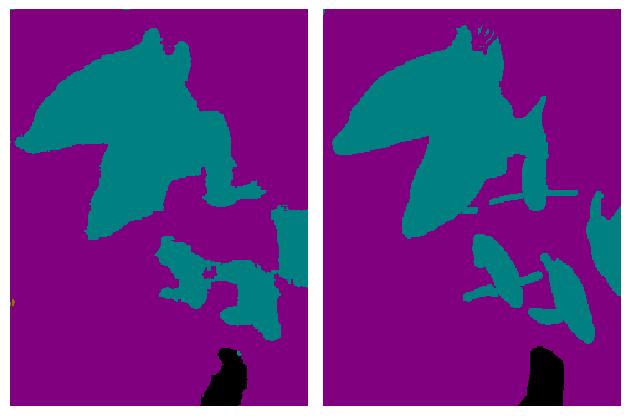

Model saved to /content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth


In [70]:
logits = encoder_decoder(images.to(device))
probs = F.softmax(logits, dim=1)
pred = probs.argmax(dim=(1), keepdim=True)
ts.show([pred[2], label_images[2]])

save_path = "/content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth"
os.makedirs("/content/drive/MyDrive/Bveri-Abschluss", exist_ok=True)
torch.save(encoder_decoder.state_dict(), save_path)
print(f"Model saved to {save_path}")

In [71]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

# Initialize metrics
total_loss = 0.0
total_pixel_acc = 0.0
num_batches = len(test_loader)

criterion = nn.CrossEntropyLoss()

# Progress bar setup
pbar = tqdm(total=num_batches)
running_loss = 0.0
running_acc = 0.0

# Disable gradient computation
with torch.no_grad():  # Correct way to disable gradients
    for i, data in enumerate(test_loader):

        images, label_masks, label_images = data

        # Move data to device
        images = images.to(device)
        label_masks = label_masks.to(device)

        # Forward pass
        logits = encoder_decoder(images)
        loss = criterion(logits, label_masks)

        # Compute predictions and pixel accuracy
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=1, keepdim=True).cpu()
        pixel_acc = (pred == label_images).to(torch.float).mean()

        # print statistics
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f"Iteration: {i + 1:5d}] Loss: {running_loss / print_every:.3f} Acc: {running_acc / print_every:.3f}"
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0
pbar.close()

Iteration:    20] Loss: 1.508 Acc: 0.722: 100%|██████████| 20/20 [00:33<00:00,  1.65s/it]


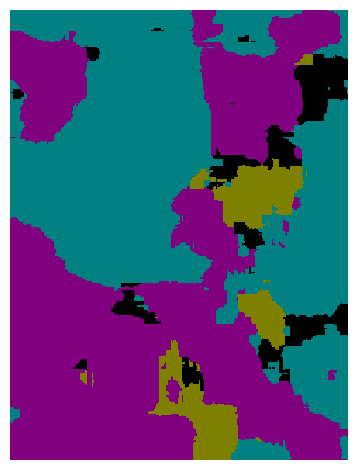

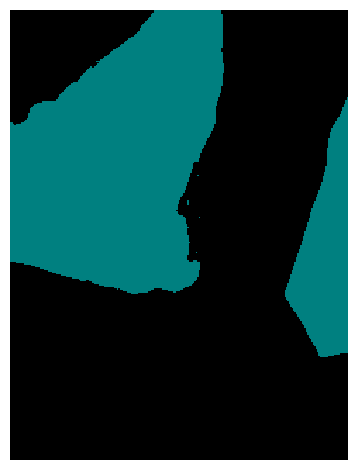

In [72]:
logits = encoder_decoder(images.to(device))
probs = F.softmax(logits, dim=1)
pred = probs.argmax(dim=(1), keepdim=True)
ts.show(pred)
ts.show(label_images)

## Model Metrics

## Suim-Net Model

## Model Comparison